In [15]:
import xarray as xr
import rioxarray
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
import numpy as np

In [2]:
ds_list = []

for idx in range(1, 5):
    ds = xr.open_dataset(f"../src/valenspy/datafiles/DYDOCASE_l{idx:02d}_pr_2021_07.nc", engine="netcdf4", chunks="auto")
    ds_list.append(ds)

<Axes: >

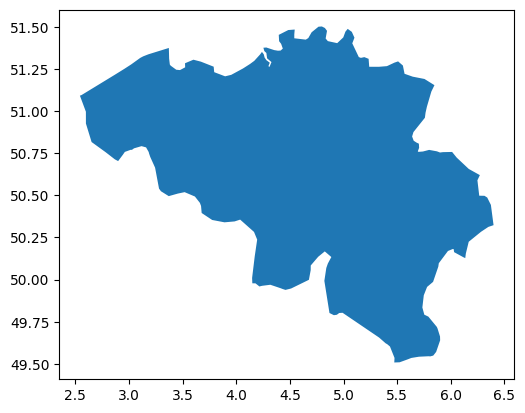

In [4]:
countries = gpd.read_file("../src/valenspy/datafiles/world-administrative-boundaries.shp")
belgium_shape = countries[countries["name"] == "Belgium"].geometry
belgium_shape.plot()

<GeoAxes: >

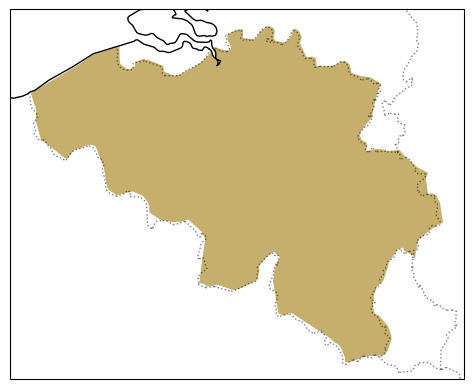

In [5]:
belgium_lcc = belgium_shape.to_crs(ds.rio.crs)
proj_dict = ds.rio.crs.to_dict()
plot_proj = ccrs.LambertConformal(central_longitude=proj_dict["lon_0"], central_latitude=proj_dict["lat_0"], standard_parallels=(proj_dict["lat_1"], proj_dict["lat_2"]), globe=ccrs.Globe(semimajor_axis=proj_dict["R"], semiminor_axis=proj_dict["R"]))
belgium_lcc_2 = belgium_shape.to_crs(plot_proj)

fig, ax = plt.subplots(subplot_kw={"projection":plot_proj})
ax.add_feature(cf.BORDERS, alpha=0.5, linestyle="dotted")
ax.add_feature(cf.COASTLINE)
belgium_lcc.plot(ax=ax, alpha=0.5)
belgium_lcc_2.plot(ax=ax, alpha=0.5, color="orange")

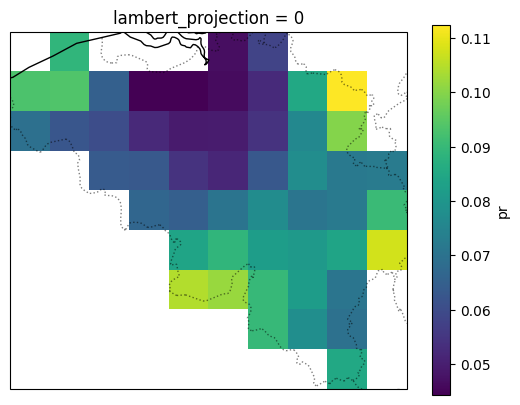

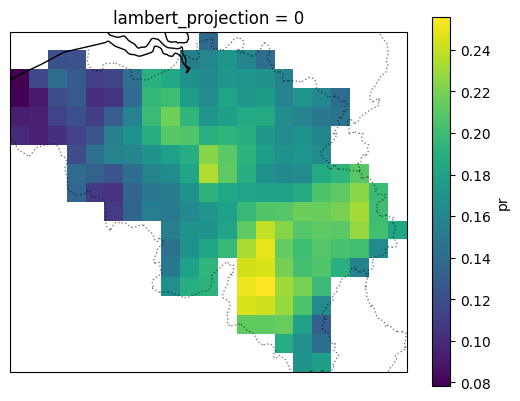

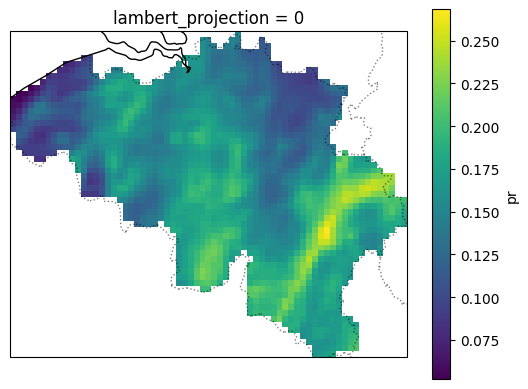

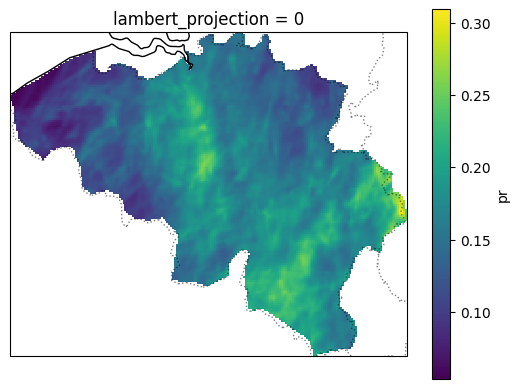

In [6]:
ds_clipped_list = list()

proj_dict = ds_list[-1].rio.crs.to_dict()
plot_proj_1km = ccrs.LambertConformal(central_longitude=proj_dict["lon_0"], central_latitude=proj_dict["lat_0"], standard_parallels=(proj_dict["lat_1"], proj_dict["lat_2"]), globe=ccrs.Globe(semimajor_axis=proj_dict["R"], semiminor_axis=proj_dict["R"]))

for ds in ds_list:
    belgium_proj = belgium_shape.to_crs(ds.rio.crs)
    proj_dict = ds.rio.crs.to_dict()
    plot_proj = ccrs.LambertConformal(central_longitude=proj_dict["lon_0"], central_latitude=proj_dict["lat_0"], standard_parallels=(proj_dict["lat_1"], proj_dict["lat_2"]), globe=ccrs.Globe(semimajor_axis=proj_dict["R"], semiminor_axis=proj_dict["R"]))

    ds_clipped = ds.rio.clip([belgium_shape[36]], ccrs.PlateCarree(), drop=True)
    ds_clipped.attrs = ds.attrs

    fig, ax = plt.subplots(subplot_kw={"projection":plot_proj})
    ax.add_feature(cf.BORDERS, alpha=0.5, linestyle="dotted")
    ax.add_feature(cf.COASTLINE)
    ds_mean = ds_clipped.mean(dim=["time"])
    ds_mean.pr.plot()

    ds_clipped_list.append(ds_clipped)

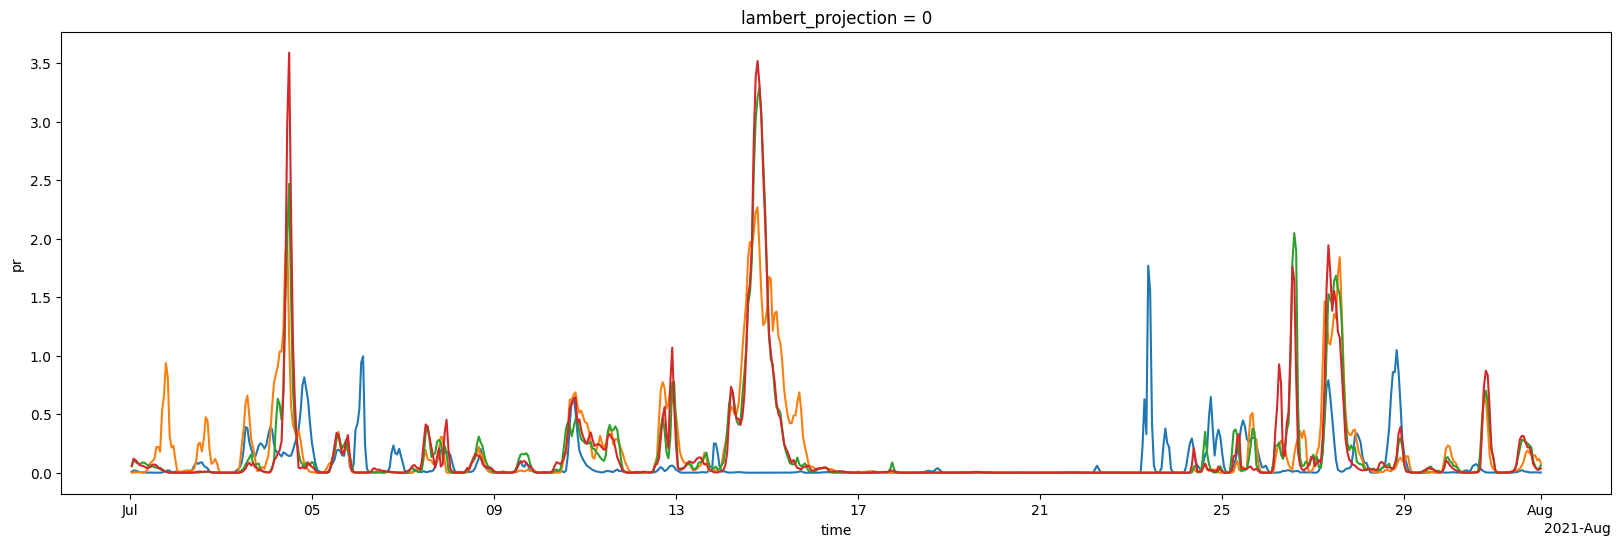

In [41]:
fig, ax = plt.subplots(figsize=(20,6))

for ds_clipped in ds_clipped_list:
    ds_clipped.mean(dim=["x", "y"]).pr.plot()

In [34]:
for ds_clipped in ds_clipped_list:
    npoints = int(np.isnan(ds_clipped.isel(time=0)).sum().pr)
    print(npoints)

39
182
1781
17285


In [37]:
print(39 * 25 * 25)
print(182 * 12.5 * 12.5)
print(1781 * 4 * 4)
print(17285 * 1.3 * 1.3)

24375
28437.5
28496
29211.65


In [43]:
ds_areal_average_list = list()
for ds_clipped in ds_clipped_list:
    ds_areal_average = ds_clipped.mean(dim=["x", "y"]).compute()
    ds_areal_average_list.append(ds_areal_average)

<xarray.DataArray 'pr' ()> Size: 8B
array(6.06014799)
Coordinates:
    lambert_projection  int32 4B 0
<xarray.DataArray 'pr' ()> Size: 8B
array(21.33597337)
Coordinates:
    lambert_projection  int32 4B 0
<xarray.DataArray 'pr' ()> Size: 8B
array(27.69763825)
Coordinates:
    lambert_projection  int32 4B 0
<xarray.DataArray 'pr' ()> Size: 8B
array(28.72125483)
Coordinates:
    lambert_projection  int32 4B 0


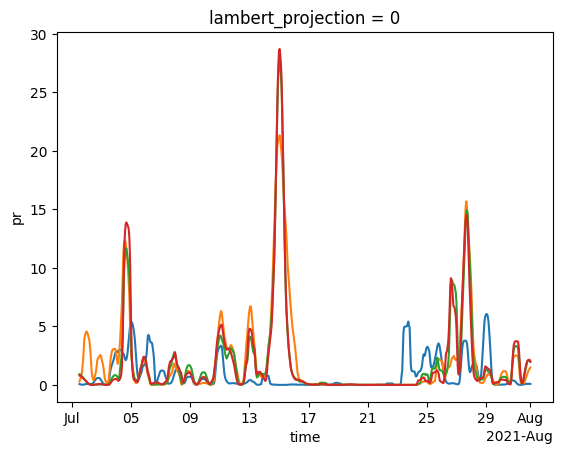

In [55]:
for ds in ds_areal_average_list:
    ds.pr.rolling(time=12).sum().plot()
    print(ds.pr.rolling(time=12).sum().max())